In [ ]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 25.5 MB/s eta 0:00:00


In [ ]:
!pip install shimmy>=0.2.1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions, max_action):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dims, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu = nn.Linear(256, n_actions)
        self.sigma = nn.Linear(256, n_actions)
        self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        sigma = self.sigma(x)
        sigma = torch.clamp(sigma, min=-20, max=2)
        return mu, sigma

    def sample_normal(self, state, reparameterize=True):
        mu, sigma = self.forward(state)
        sigma = sigma.exp()
        probabilities = torch.distributions.Normal(mu, sigma)
        if reparameterize:
            actions = probabilities.rsample()
        else:
            actions = probabilities.sample()
        action = torch.tanh(actions) * self.max_action
        log_probs = probabilities.log_prob(actions)
        log_probs -= torch.log(1 - action.pow(2) + 1e-6)
        log_probs = log_probs.sum(1, keepdim=True)
        return action, log_probs

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dims + n_actions, 256)
        self.fc2 = nn.Linear(256, 256)
        self.q = nn.Linear(256, 1)

    def forward(self, state, action):
        q_input = torch.cat([state, action], 1)
        x = F.relu(self.fc1(q_input))
        x = F.relu(self.fc2(x))
        q_value = self.q(x)
        return q_value

class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

    def store_transition(self, state, action, reward, next_state, done):
        # Your code to store the transition in the buffer
        pass


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class ReplayBuffer:
    def __init__(self, mem_size, input_shape, n_actions):
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(CriticNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims + n_actions, 256)
        self.fc2 = nn.Linear(256, 256)
        self.q = nn.Linear(256, 1)

    def forward(self, state, action):
        q1_action_value = self.fc1(torch.cat([state, action], dim=1))
        q1_action_value = nn.ReLU()(q1_action_value)
        q1_action_value = self.fc2(q1_action_value)
        q1_action_value = nn.ReLU()(q1_action_value)
        q1 = self.q(q1_action_value)

        return q1

class ActorNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(*input_dims, 256)
        self.fc2 = nn.Linear(256, 256)
        self.mu = nn.Linear(256, n_actions)

    def forward(self, state):
        prob = self.fc1(state)
        prob = nn.ReLU()(prob)
        prob = self.fc2(prob)
        prob = nn.ReLU()(prob)
        mu = self.mu(prob)

        return mu

class ESCPAgent:
    def __init__(self, input_dims, n_actions, lr, gamma, tau, alpha, batch_size, mem_size, max_action):
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, input_shape=input_dims, n_actions=n_actions)
        self.max_action = max_action

        self.actor = ActorNetwork(input_dims=input_dims, n_actions=n_actions)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)

        self.critic_1 = CriticNetwork(input_dims=input_dims, n_actions=n_actions)
        self.critic_2 = CriticNetwork(input_dims=input_dims, n_actions=n_actions)
        self.critic_1_optimizer = optim.Adam(self.critic_1.parameters(), lr=lr)
        self.critic_2_optimizer = optim.Adam(self.critic_2.parameters(), lr=lr)

        self.target_critic_1 = CriticNetwork(input_dims=input_dims, n_actions=n_actions)
        self.target_critic_2 = CriticNetwork(input_dims=input_dims, n_actions=n_actions)

        self.update_network_parameters(tau=1)





    def choose_action(self, observation):
        self.actor.eval()  # Set the network to evaluation mode
        state = torch.tensor([observation], dtype=torch.float32)
        actions = self.actor(state).cpu().detach().numpy()[0]
        self.actor.train()  # Set the network back to train mode
        return np.clip(actions, -self.max_action, self.max_action)  # Clip actions to be within the action space

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # Update the target network parameters slowly
        # based on the current network parameters and tau
        # ...

    def learn(self):
        # Ensure that we have enough samples in the replay buffer
        if self.memory.mem_cntr < self.batch_size:
            return

        # Sample a batch of experiences from the replay buffer
        # Perform learning step
        # ...


    def store_transition(self, state, action, reward, next_state, done):
        self.memory.store_transition(state, action, reward, next_state, done)







In [ ]:
import gym
from gym import spaces
import numpy as np

class NSCartPoleV0(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(NSCartPoleV0, self).__init__()

        # Define a continuous action space where the magnitude of the force can be between -10 and 10
        self.action_space = spaces.Box(low=-10.0, high=10.0, shape=(1,), dtype=np.float32)

        # Define the observation space with the physics limits of the system
        high = np.array([
            np.finfo(np.float32).max,  # cart position, no limit
            np.finfo(np.float32).max,  # cart velocity
            np.pi,                     # pole angle from vertical
            np.finfo(np.float32).max   # pole velocity at tip
        ], dtype=np.float32)

        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        # Physical system parameters
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * np.pi / 360
        self.x_threshold = 2.4

        # Initialize state variables
        self.state = None
        self.steps_beyond_done = None

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        state = self.state
        x, x_dot, theta, theta_dot = state
        force = action[0]

        # Physics for updating the state
        costheta = np.cos(theta)
        sintheta = np.sin(theta)

        # For the inverted pendulum dynamics refer to: http://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0/3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        # Update the four state variables, using Euler's method for simplicity
        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc

        self.state = (x, x_dot, theta, theta_dot)

        done = x < -self.x_threshold \
               or x > self.x_threshold \
               or theta < -self.theta_threshold_radians \
               or theta > self.theta_threshold_radians
        done = bool(done)

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                print("You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.")
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human', close=False):
        # Implement this method if you want to do rendering
        pass

    def close(self):
        # Implement this method for any cleanup when closing the environment
        pass
    def reset(self):
      self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
      self.steps_beyond_done = None

    # Change gravity each episode to introduce non-stationarity
      self.gravity = np.random.uniform(9.0, 10.0)

      return np.array(self.state)



In [ ]:
import gym
import numpy as np

class NonStationaryWrapper(gym.Wrapper):
    def __init__(self, env, gravity_range=(9.0, 10.0), change_every_n_episodes=10):
        super(NonStationaryWrapper, self).__init__(env)
        self.gravity_range = gravity_range
        self.change_every_n_episodes = change_every_n_episodes
        self.episode_count = 0

    def reset(self, **kwargs):
        # Change gravity every `change_every_n_episodes` episodes
        if self.episode_count % self.change_every_n_episodes == 0:
            new_gravity = np.random.uniform(*self.gravity_range)
            self.env.gravity = new_gravity
            print(f"Changing environment gravity to {new_gravity}")

        self.episode_count += 1
        return self.env.reset(**kwargs)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, n_actions):
        super(CriticNetwork, self).__init__()
        # Combine the input dimensions and number of actions correctly
        self.fc1 = nn.Linear(input_dims[0] + n_actions, 256)
        self.fc2 = nn.Linear(256, 256)
        self.q = nn.Linear(256, 1)

<ipython-input-4-81e268ccabc3>:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  state = torch.tensor([observation], dtype=torch.float32)


Episode 1: Reward = 30.0
Episode 2: Reward = 33.0
Episode 3: Reward = 39.0
Episode 4: Reward = 28.0
Episode 5: Reward = 51.0
Episode 6: Reward = 32.0
Episode 7: Reward = 28.0
Episode 8: Reward = 31.0
Episode 9: Reward = 54.0
Episode 10: Reward = 31.0
Episode 11: Reward = 65.0
Episode 12: Reward = 43.0
Episode 13: Reward = 29.0
Episode 14: Reward = 66.0
Episode 15: Reward = 46.0
Episode 16: Reward = 63.0
Episode 17: Reward = 31.0
Episode 18: Reward = 36.0
Episode 19: Reward = 27.0
Episode 20: Reward = 40.0
Episode 21: Reward = 48.0
Episode 22: Reward = 50.0
Episode 23: Reward = 65.0
Episode 24: Reward = 39.0
Episode 25: Reward = 34.0
Episode 26: Reward = 40.0
Episode 27: Reward = 37.0
Episode 28: Reward = 29.0
Episode 29: Reward = 32.0
Episode 30: Reward = 41.0
Episode 31: Reward = 33.0
Episode 32: Reward = 37.0
Episode 33: Reward = 35.0
Episode 34: Reward = 40.0
Episode 35: Reward = 34.0
Episode 36: Reward = 59.0
Episode 37: Reward = 31.0
Episode 38: Reward = 64.0
Episode 39: Reward = 

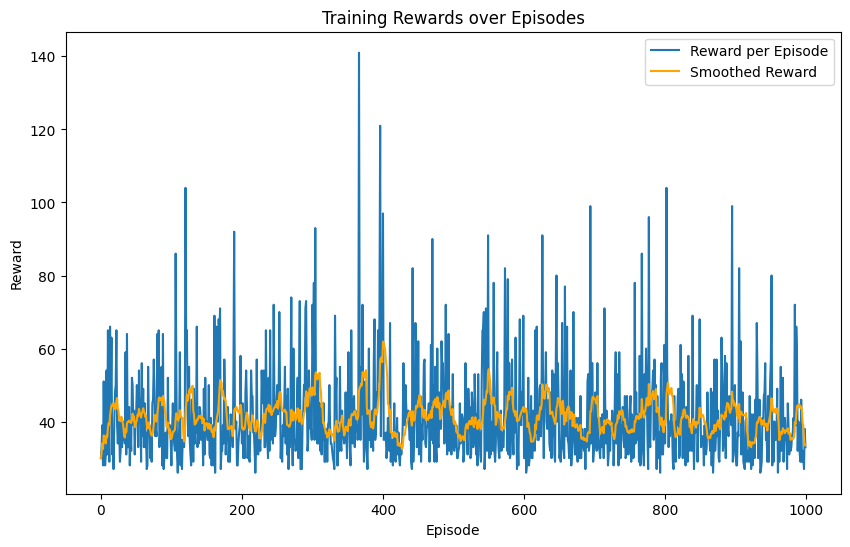

In [ ]:
import matplotlib.pyplot as plt

def train_agent(env, agent, n_episodes=100):
    all_rewards = []

    for episode in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.choose_action(obs)
            new_obs, reward, done, _ = env.step(action)

            agent.store_transition(obs, action, reward, new_obs, done)
            agent.learn()

            obs = new_obs
            episode_reward += reward

        all_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}")

    return all_rewards

if __name__ == '__main__':
    env = NSCartPoleV0()  # Ensure NSCartPoleV0 is defined properly with continuous action space
    input_dims = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    max_action = env.action_space.high[0]  # Assuming symmetric action space

    agent = ESCPAgent(input_dims=[input_dims], n_actions=n_actions, lr=0.001, gamma=0.99,
                      tau=0.005, alpha=0.2, batch_size=64, mem_size=1000000, max_action=max_action)

    n_episodes = 1000
    all_rewards = train_agent(env, agent, n_episodes)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(all_rewards, label='Reward per Episode')

    smoothed_rewards = [np.mean(all_rewards[max(0, i-10):i+1]) for i in range(len(all_rewards))]
    plt.plot(smoothed_rewards, color='orange', label='Smoothed Reward')

    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Training Rewards over Episodes')
    plt.legend()
    plt.show()


In [ ]:
import random

import gym
import numpy as np


class GridWorld(gym.Env):
    def __init__(self, env_flag=2, append_context=False, continuous_action=True):
        super(gym.Env).__init__()
        self.deterministic = True
        # A, B, C, s_0, D
        # ------------------------
        # |    A, B, C   | None  |
        # ------------------------
        # |      s_0     |  D    |
        # ------------------------
        # 0 stay
        # 1 up
        # 2 right
        # 3 left
        # 4 down
        self.continuous_action = continuous_action
        if self.continuous_action:
            self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,))
        else:
            self.action_space = gym.spaces.Discrete(5)

        self.observation_space = None
        self._grid_escape_time = 0
        self._grid_max_time = 1000
        self._current_position = 0
        self.env_flag = env_flag
        self.append_context = append_context
        self.middle_state = [2, 3, 4]
        assert self.env_flag in self.middle_state, '{} is accepted.'.format(self.middle_state)
        self._ind_to_name = {
            0: 's0',
            1: 'D',
            2: 'A',
            3: 'B',
            4: 'C',
            5: 'None'
        }
        self.reward_setting = {
            0: 0,
            1: 1,
            2: 10,
            3: -10,
            4: 0,
            5: 0
        }
        for k in self.reward_setting:
            self.reward_setting[k] *= 0.1

        self.state_space = len(self.reward_setting)
        self._raw_state_length = self.state_space
        if self.append_context:
            self.state_space += len(self.middle_state)
        self.diy_env = True
        self.observation_space = gym.spaces.Box(0, 1, (self.state_space, ))

    @property
    def middle_state_embedding(self):
        v = [0] * len(self.middle_state)
        v[self.env_flag - 2] = 1
        return v

    def make_one_hot(self, state):
        vec = [0] * self._raw_state_length
        vec[state] = 1
        return vec

    def get_next_position_toy(self, action):
        if self._current_position == 0:
            if action == 0:
                # to D
                next_state = 1
            else:
                # to unknown position
                next_state = self.env_flag
        # elif self._current_position == 1:
        #     # keep at D
        #     next_state = 1
        elif self._current_position in self.middle_state + [1]:
            # to s0
            next_state = 0
        else:
            raise NotImplementedError('current position exceeds range!!!')
        return next_state

    def get_next_position(self, action):
        # ------------------------
        # |    A, B, C   | None  |
        # ------------------------
        # |      s_0     |  D    |
        # ------------------------
        # action: 0 stay
        # action: 1 up
        # action: 2 right
        # action: 3 left
        # action: 4 down
        # self._ind_to_name = {
        #             0: 's0',
        #             1: 'D',
        #             2: 'A',
        #             3: 'B',
        #             4: 'C',
        #             5: 'None'
        #         }
        if not self.deterministic:
            if random.random() > 0.5:
                action = action
            else:
                action = random.randint(0, 4)
        if action == 0:
            if self._current_position in [2, 3, 4]:
                return self.env_flag
            return self._current_position
        left_up_map = {
            4: 0,
            # 2: 5
        }
        action_transition_mapping = \
        {
            0: {1: self.env_flag, 2: 1},
            1: {1: 5, 3: 0},
            5: {3: self.env_flag, 4:1},
            2: left_up_map,
            3: left_up_map,
            4: left_up_map
        }
        action_to_state = action_transition_mapping[self._current_position]
        if action in action_to_state:
            return action_to_state[action]
        if self._current_position in [2, 3, 4]:
            return self.env_flag
        return self._current_position

    def step(self, action):
        self._grid_escape_time += 1
        info = {}
        if self.continuous_action:
            action_tmp = (action[0] + 1) / 2
            action_tmp = int(action_tmp * 5)
            if action_tmp >= 5:
                action_tmp = 4
            next_state = self.get_next_position(action_tmp)
        else:
            assert isinstance(action, int), 'action should be int type rather than {}'.format(type(action))
            next_state = self.get_next_position(action)
        done = False # next_state == 1
        if self._grid_escape_time >= self._grid_max_time:
            done = True
        reward = self.reward_setting[next_state]
        info['current_position'] = self._ind_to_name[next_state]
        next_state_vector = self.make_one_hot(next_state)
        self._current_position = next_state
        if self.append_context:
            next_state_vector += self.middle_state_embedding
        return next_state_vector, reward, done, info

    def reset(self):
        self._grid_escape_time = 0
        self._current_position = 0
        state = self.make_one_hot(self._current_position)
        if self.append_context:
            state += self.middle_state_embedding
        return state

    def seed(self, seed=None):
        self.action_space.seed(seed)


class RandomGridWorld(GridWorld):
    def __init__(self, append_context=False):
        self.possible_choice = [2, 3, 4]
        self.renv_flag = random.choice(self.possible_choice)
        self.fix_env = None
        super(RandomGridWorld, self).__init__(self.renv_flag, append_context)

    def reset(self):
        if self.fix_env is None:
            self.renv_flag = random.choice(self.possible_choice)
            self.env_flag = self.renv_flag
        else:
            self.renv_flag = self.env_flag = self.fix_env
        return super(RandomGridWorld, self).reset()

    def set_fix_env(self, fix_env):
        self.renv_flag = self.env_flag = self.fix_env = fix_env

    def set_task(self, task):
        self.set_fix_env(task)

    def sample_tasks(self, n_tasks):
        if n_tasks < len(self.possible_choice):
            tasks = [random.choice(self.possible_choice) for _ in range(n_tasks)]
        else:
            tasks = []
            for i in range(n_tasks):
                tasks.append(self.possible_choice[i % len(self.possible_choice)])

        return tasks

    @property
    def env_parameter_vector_(self):
        return np.array([(self.renv_flag - np.min(self.possible_choice)) / (np.max(self.possible_choice)
                                                                            - np.min(self.possible_choice))])

    @property
    def env_parameter_length(self):
        return 1

from gym.envs.registration import register

register(
id='NSCartPoleV0', entry_point=RandomGridWorld
)

if __name__ == '__main__':
    import gym
    env = gym.make('NSCartPoleV0')
    print('observation space: ', env.observation_space)
    print('action space: ', env.action_space)
    print(hasattr(env, 'rmdm_env_flag'))


observation space:  Box(0.0, 1.0, (6,), float32)
action space:  Box(-1.0, 1.0, (1,), float32)
False


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import random
import gym
import matplotlib.pyplot as plt
from stable_baselines3 import SAC
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

# Define the environment creation function
def create_env():
    return RandomGridWorld(append_context=True)

# Create the environment
env = DummyVecEnv([create_env])

# Define and create the SAC model
model = SAC("MlpPolicy", env, verbose=1)

# Training parameters
total_timesteps = 100000

# Train the model
model.learn(total_timesteps=total_timesteps)

# Evaluate the trained model
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean Reward: {mean_reward:.2f}")

# Save the model
model.save("sac")


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 36       |
|    time_elapsed    | 108      |
|    total_timesteps | 4000     |
| train/             |          |
|    actor_loss      | -12.3    |
|    critic_loss     | 0.172    |
|    ent_coef        | 0.332    |
|    ent_coef_loss   | -1.43    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3899     |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 36       |
|    time_elapsed    | 219      |
|    total_timesteps | 8000     |
| train/             |          |
|    actor_loss      | -21.4    |
|    critic_loss     | 0.0453   |
|    ent_coef        | 0.112    |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 7899     |
---------------------------------
-------------------------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean Reward: 350.00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


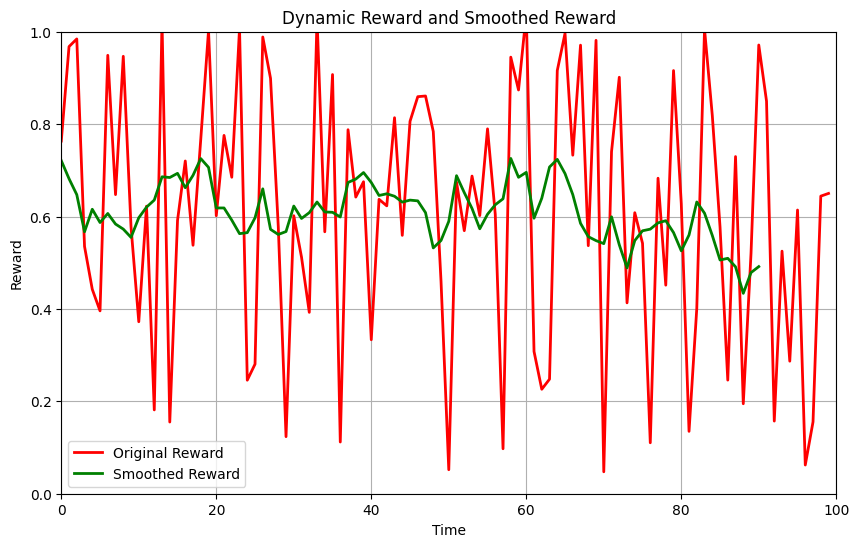

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Number of data points in the learning curve
num_points = 100

# Initialize an empty learning curve with random data
learning_curve = np.random.rand(num_points)

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize the plot with two empty curves (original in blue, smoothed in green)
line1, = ax.plot([], [], lw=2, color='red', label='Original Reward')
line2, = ax.plot([], [], lw=2, color='green', label='Smoothed Reward')
ax.set_xlim(0, num_points)
ax.set_ylim(0, 1)
ax.legend()  # Add a legend

# Define the window size for the moving average
window_size = 10

# Update function to simulate changes in the learning curve and apply smoothing
def update(frame):
    if frame < num_points:
        # Simulate changes in the learning curve with random data
        learning_curve[frame:] += np.random.uniform(-0.1, 0.1)
        # Apply a simple moving average to smooth the curve
        smoothed_curve = np.convolve(learning_curve, np.ones(window_size)/window_size, mode='valid')
        line1.set_data(range(num_points), learning_curve)
        line2.set_data(range(len(smoothed_curve)), smoothed_curve)
        return line1, line2  # Return both lines

# Create the animation
ani = FuncAnimation(fig, update, frames=num_points, repeat=False, blit=True)

# Display the dynamic learning curves
plt.xlabel("Time")
plt.ylabel("Reward")
plt.title("Dynamic Reward and Smoothed Reward")
plt.grid()
plt.show()